# Ultimate Technologies Inc. Take-Home Challenge
By Hanna Seyoum

Ultimate Technologies Inc. is an American worldwide online transportation network company that has disrupted the taxi and logistics industry and is a prestigious company to work at.

The goal of this challenge is to analyze user logins and predict rider retention.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=0.7)
sns.set_palette("Greens_r")

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

**Part 1: EDA**

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. I will aggregate these login counts based on 15-minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand.

In [2]:
df_logins = pd.read_json("logins.json")

In [3]:
df_logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


`login_time` is already in datetime format.

In [4]:
df_15min = df_logins.resample("15Min", on="login_time").count()
df_15min.rename(columns={"login_time": "login_count"}, inplace=True)

In [5]:
df_15min.head()

login_count
login_time                      
1970-01-01 20:00:00            2
1970-01-01 20:15:00            6
1970-01-01 20:30:00            9
1970-01-01 20:45:00            7
1970-01-01 21:00:00            1

Text(0, 0.5, 'Number of Logins')

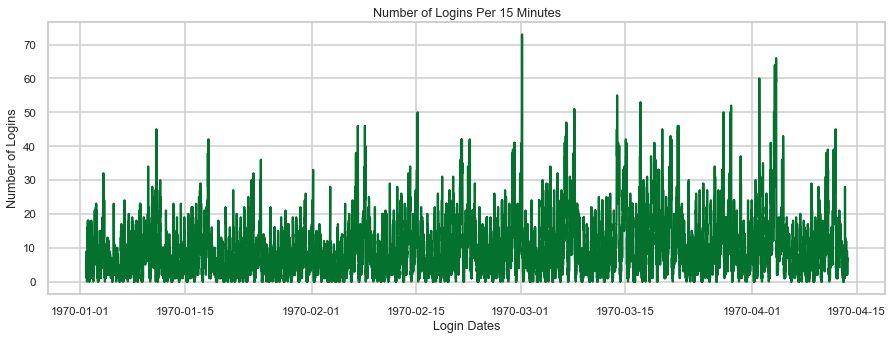

In [6]:
plt.subplots(figsize = (15,5))
plt.plot(df_15min.index, df_15min.login_count)
plt.title("Number of Logins Per 15 Minutes")
plt.xlabel("Login Dates")
plt.ylabel("Number of Logins")

It's clear from the above plot that there is a trend with the number of logins. I will investigate further by calculating the number of logins by the day of the week.

In [7]:
df_login_weekdays = df_logins.resample("B", on="login_time").count().rename(columns={"login_time": "login_count"})
df_login_fri = df_logins.resample("W-FRI", on="login_time").count().rename(columns={"login_time": "login_count"})
df_login_sat = df_logins.resample("W-SAT", on="login_time").count().rename(columns={"login_time": "login_count"})
df_login_sun = df_logins.resample("W-SUN", on="login_time").count().rename(columns={"login_time": "login_count"})

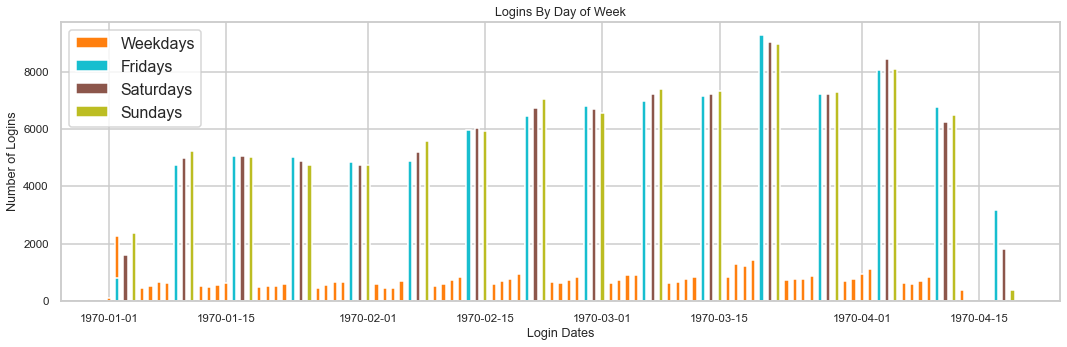

In [8]:
plt.subplots(figsize = (15,5))

plt.bar(df_login_weekdays.index, df_login_weekdays.login_count, width=0.5, label="Weekdays", color="tab:orange")
plt.bar(df_login_fri.index, df_login_fri.login_count, width=0.5, label="Fridays", color="tab:cyan")
plt.bar(df_login_sat.index, df_login_sat.login_count, width=0.5, label="Saturdays", color="tab:brown")
plt.bar(df_login_sun.index, df_login_sun.login_count, width=0.5, label="Sundays", color="tab:olive")

plt.title("Logins By Day of Week")
plt.xlabel("Login Dates")
plt.ylabel("Number of Logins")

plt.legend(loc="upper left", fontsize = 16)
plt.tight_layout()

Next I'll look at logins by hour of day. 

In [9]:
df_login_hourly = df_logins.resample("H", on="login_time").count().rename(columns={"login_time": "login_count"})

In [10]:
# df_login_hourly = round(df_login_hourly.groupby(df_login_hourly.index.hour).mean())

In [11]:
day_of_week = list(df_login_hourly.index.dayofweek)
hour_of_day = [time.hour for time in df_login_hourly.index]
df_login_hourly["day_of_week"] = day_of_week
df_login_hourly["hour_of_day"] = hour_of_day
df_login_hourly.head()

login_count  day_of_week  hour_of_day
login_time                                                
1970-01-01 20:00:00           24            3           20
1970-01-01 21:00:00            9            3           21
1970-01-01 22:00:00           21            3           22
1970-01-01 23:00:00           58            3           23
1970-01-02 00:00:00           53            4            0

In [12]:
df_login_hourly = pd.pivot_table(df_login_hourly, index="hour_of_day", 
                       columns="day_of_week", values="login_count", 
                       aggfunc=np.mean
                      ).rename(columns={0:"Monday", 1:"Tuesday", 2:"Wednesday", 3:"Thursday", 4:"Friday", 5:"Saturday", 6:"Sunday"})

df_login_hourly.head()

day_of_week     Monday    Tuesday  Wednesday   Thursday     Friday  \
hour_of_day                                                          
0            35.400000  43.357143  49.071429  58.285714  65.000000   
1            27.600000  40.428571  49.000000  55.500000  63.800000   
2            20.800000  28.142857  34.428571  44.642857  51.400000   
3            15.733333  14.142857  21.357143  26.785714  33.466667   
4            13.733333  10.642857  17.500000  18.214286  23.533333   

day_of_week    Saturday      Sunday  
hour_of_day                          
0             83.600000   74.866667  
1            104.133333   90.333333  
2            107.200000  107.200000  
3            104.933333  109.800000  
4            114.600000  140.466667

In [13]:
df_login_hourly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24 entries, 0 to 23
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Monday     24 non-null     float64
 1   Tuesday    24 non-null     float64
 2   Wednesday  24 non-null     float64
 3   Thursday   24 non-null     float64
 4   Friday     24 non-null     float64
 5   Saturday   24 non-null     float64
 6   Sunday     24 non-null     float64
dtypes: float64(7)
memory usage: 1.5 KB


In [14]:
df_login_hourly = df_login_hourly.stack()
df_login_hourly.name = "avg_logins"
#df_login_hourly.reset_index() # this isn't making any difference

In [15]:
df_login_hourly

hour_of_day  day_of_week
0            Monday         35.400000
             Tuesday        43.357143
             Wednesday      49.071429
             Thursday       58.285714
             Friday         65.000000
                              ...    
23           Wednesday      64.857143
             Thursday       68.866667
             Friday         86.533333
             Saturday       67.066667
             Sunday         37.133333
Name: avg_logins, Length: 168, dtype: float64

In [16]:
# will changing it to dataframe solve issue?
# df_login_hourly = pd.DataFrame(df_login_hourly)

**Part 2: Experiment and metrics design**  

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.  

However, a toll bridge, with a two-way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.  

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

a. how you will implement the experiment  
b. what statistical test(s) you will conduct to verify the significance of the observation    
c. how you would interpret the results and provide recommendations to the city  
operations team along with any caveats.

**The metric I would use as a measure of success of this experiement is the number of drivers who have driven accross the bridge on a weekday, since that's when the two cities have opposing schedules. i.e., when it's slow in Gotham during the day and busy in Metropolis, Gotham drivers could head over to metropolis for work.**

**To conduct the experiment I would first obtain a dataset on the drivers, a dataset that has information about the drivers' city, and if whether or not they've crossed the bridge on the job. I would then do a hypothesis test comparing the # of drivers crossing the bridge before and after toll reimbursements have commenced.**

**Part 3:**  

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014.  
___
create `user-retained` feature:   
1: user was “active” (i.e. took a trip) in the preceding 30 days  
0: otherwise

-make this feature the target feature  
-classification problem  

___
Use this dataset to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

In [17]:
df_ultimate_data = pd.read_json("ultimate_data_challenge.json")

In [18]:
df_ultimate_data.head()

city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17   iPhone       15.4                 True   
1       1.00     2014-05-05  Android        0.0                False   
2       1.00     2014-01-07   iPhone        0.0                False   
3       1.14     2014-06-29   iPhone       20.0                 True   
4       1.19     2014-03-15  Android       11.8                False   

   weekday_pct  avg_dist  avg_rating_by_driver  
0         46.2      3.67                   5.0  
1         50.0      8.26                   5.0  
2        100.0      0.77                   5.0  
3         80.0      2.36                   4.9  
4         82.4      3.13                   4.9

In [19]:
user_retained = []

for i in range(len(df_ultimate_data)):
    if df_ultimate_data["trips_in_first_30_days"][i] > 0:
        user_retained.append(1)
    else:
        user_retained.append(0)

df_ultimate_data["user_retained"] = user_retained

In [20]:
df_ultimate_data.head()

city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17   iPhone       15.4                 True   
1       1.00     2014-05-05  Android        0.0                False   
2       1.00     2014-01-07   iPhone        0.0                False   
3       1.14     2014-06-29   iPhone       20.0                 True   
4       1.19     2014-03-15  Android       11.8                False   

   weekday_pct  avg_dist  avg_rating_by_driver  user_retained  
0         46.2      3.67                   5.0              1  
1         50.0      8.26                   5.0              0  
2        100.0      0.77                   5.0              1  
3         80.0      2.36                   4.9              1  
4         82.4      3.13                   4.9              1

In [21]:
X = df_ultimate_data.drop("user_retained", axis=1)
y = df_ultimate_data[["user_retained"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)
